# Near shift-invariance in the Interpolated DWT (IDWT) domain

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mimg
%matplotlib inline
import pywt

### Create the three images
With a circle of diameter 10 that moves from coordinate (20,30), (21,30), and (22, 30).

In [2]:
%%bash
/home/vruiz/MRVC/tools/moving_circle.sh -w 128 -h 128 -x 20 -y 30 -d 10 -f 3
mv /tmp/moving_circle_000.png .
mv /tmp/moving_circle_001.png .
mv /tmp/moving_circle_002.png .

/home/vruiz/MRVC/tools/moving_circle.sh: parsing: -w 128 -h 128 -x 20 -y 30 -d 10 -f 3
image_width = 128
image_height = 128
Initial X coordinate = 20
Initial Y coordinate = 30
diameter = 10
frames = 3


+ i=0
+ '[' 0 -le 2 ']'
++ printf %03d 0
+ ii=000
+ convert -size 128x128 xc:skyblue -fill white -stroke black -draw 'circle 20,30 30,30' /tmp/moving_circle_000.png
+ i=1
+ '[' 1 -le 2 ']'
++ printf %03d 1
+ ii=001
+ convert -size 128x128 xc:skyblue -fill white -stroke black -draw 'circle 21,30 31,30' /tmp/moving_circle_001.png
+ i=2
+ '[' 2 -le 2 ']'
++ printf %03d 2
+ ii=002
+ convert -size 128x128 xc:skyblue -fill white -stroke black -draw 'circle 22,30 32,30' /tmp/moving_circle_002.png
+ i=3
+ '[' 3 -le 2 ']'


### Displaying stuff

In [3]:
def normalize(img):
    max_component = np.max(img)
    min_component = np.min(img)
    max_min_component = max_component - min_component
    return (img-min_component)/max_min_component

def show_img(prefix):
    img = load_img(prefix)
    img = normalize(img)
    plt.figure(figsize=(10,10))
    plt.title(prefix, fontsize=20)
    plt.imshow(img)
    
def load_frame(prefix):
    fn = f"{prefix}.png"
    print(fn)
    frame = cv2.imread(fn, cv2.IMREAD_UNCHANGED) # [rows, columns, components]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = np.array(frame)
    frame = frame.astype(np.float32) - 32768.0
    return frame

def write_frame(frame, prefix):
    frame = frame.astype(np.float32)
    frame += 32768.0
    frame = frame.astype(np.uint16)
    cv2.imwrite(f"{prefix}.png", frame)

def show_seq(prefix="/tmp/", frames=5):
    for i in range(frames):
        show_img(f"{prefix}{i:03d}")

def show_motion(prefix="/tmp/", frames=5):
    plt.figure(figsize=(10,10))
    prev = load_frame(f"{prefix}000")
    imgplot = plt.imshow(normalize(prev))
    for i in range(1, frames, 1):
        img = load_frame(f"{prefix}{i:03d}")
        diff = img - prev
        prev = img
        diff = normalize(diff)
        plt.figure(figsize=(10,10))
        plt.title(f"{prefix}{i:03d}", fontsize=20)
        plt.imshow(diff)

### Show the sequence

moving_circle_000.png
moving_circle_001.png
moving_circle_002.png


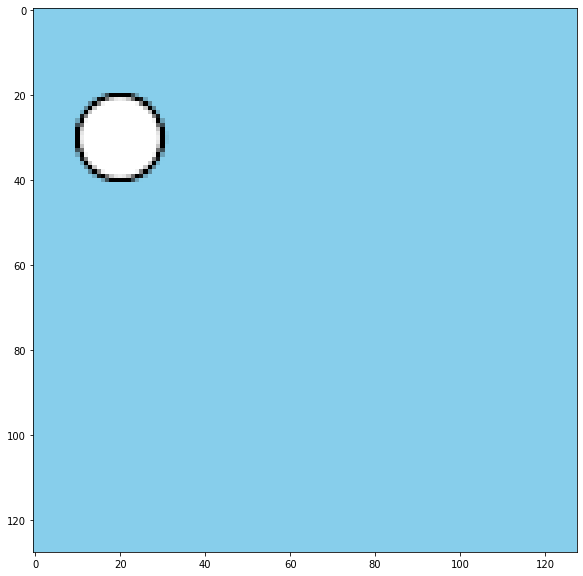

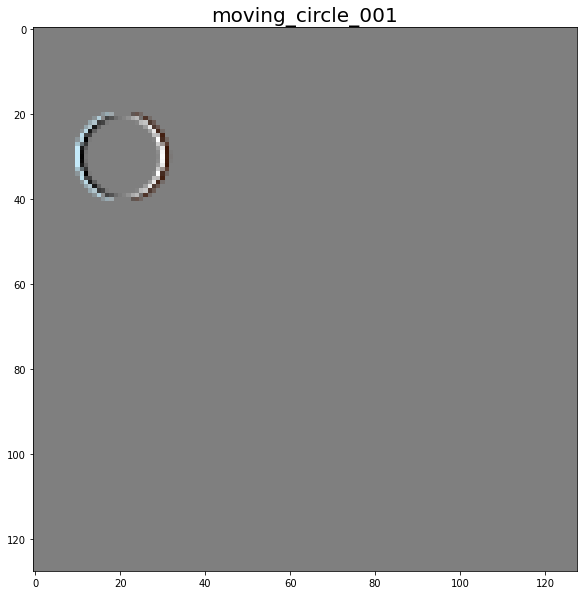

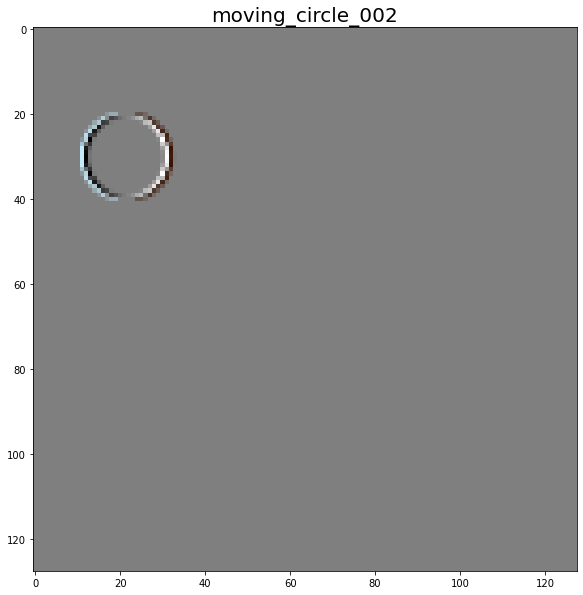

In [4]:
prefix = "moving_circle_"
show_motion(prefix, frames=3)

### Color transform stuff

In [5]:
def RGB_to_YCoCg(RGB_frame):
    R, G, B = RGB_frame[:,:,0], RGB_frame[:,:,1], RGB_frame[:,:,2]
    YCoCg_frame = np.empty_like(RGB_frame)
    YCoCg_frame[:,:,0] =  R/4 + G/2 + B/4 
    YCoCg_frame[:,:,1] =  R/2       - B/2
    YCoCg_frame[:,:,2] = -R/4 + G/2 - B/4
    return YCoCg_frame

### Load the images

In [6]:
frame_0 = load_frame(prefix + "000")
frame_1 = load_frame(prefix + "001")
frame_2 = load_frame(prefix + "002")
write_frame(frame_1-frame_0, "difference_0")
write_frame(frame_2-frame_0, "difference_1")

moving_circle_000.png
moving_circle_001.png
moving_circle_002.png


### Work only with luma

In [7]:
frame_0_Y = RGB_to_YCoCg(frame_0)[:,:,0]
frame_1_Y = RGB_to_YCoCg(frame_1)[:,:,0]
frame_2_Y = RGB_to_YCoCg(frame_2)[:,:,0]

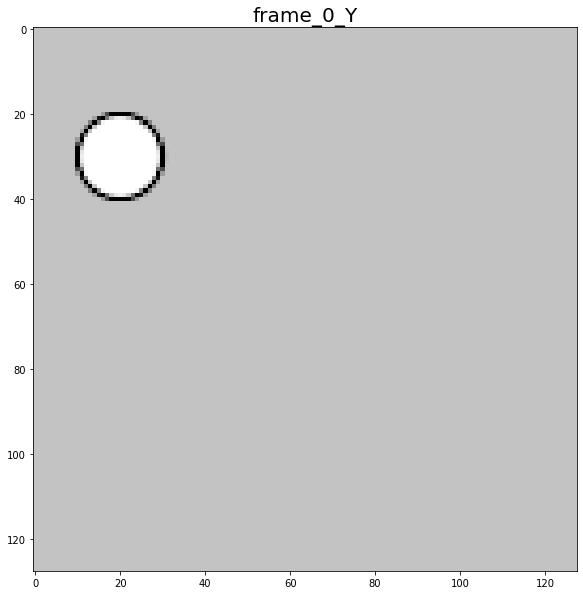

In [8]:
plt.figure(figsize=(10,10))
plt.title("frame_0_Y", fontsize=20)
plt.imshow(frame_0_Y, cmap='gray')
plt.show()

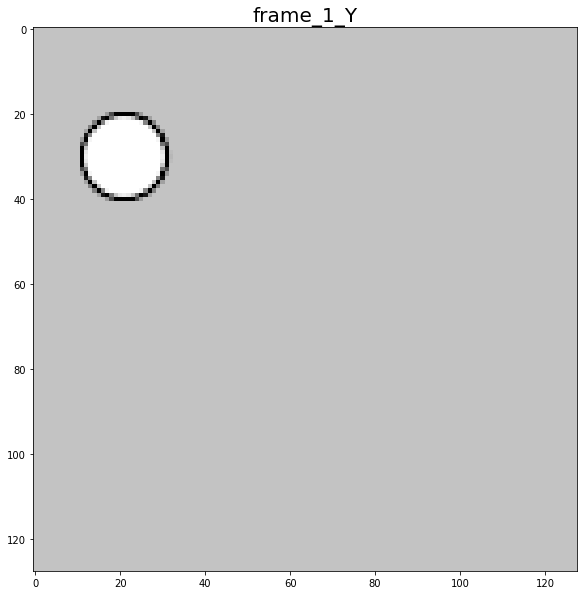

In [9]:
plt.figure(figsize=(10,10))
plt.title("frame_1_Y", fontsize=20)
plt.imshow(frame_1_Y, cmap='gray')
plt.show()

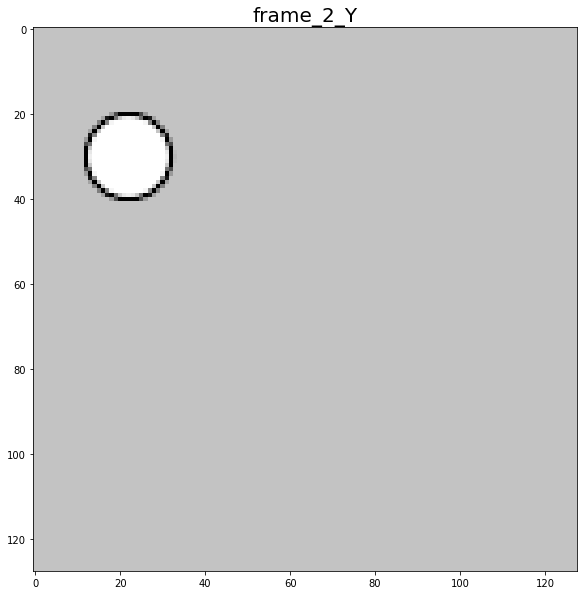

In [10]:
plt.figure(figsize=(10,10))
plt.title("frame_2_Y", fontsize=20)
plt.imshow(frame_2_Y, cmap='gray')
plt.show()

### Motion estimation (ME) in the pixel domain
Notice that this ME would be used if the original frames where available. This is not the case in MRVC!

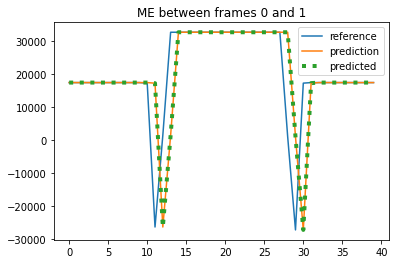

In [11]:
# Plot the first part (from pixel 0 to 39) of the horizontal line (row 35) of the luminance.
plt.title("ME between frames 0 and 1")
plt.plot(frame_0_Y[35, 0:40], label="reference")
plt.plot(np.roll(frame_0_Y[35, 0:40], 1), label="prediction")
#plt.show()
plt.plot(frame_1_Y[35, 0:40], linestyle=':', linewidth=4, label="predicted")
plt.legend()
plt.savefig("movement_0.svg")
plt.savefig("movement_0.pdf")
plt.show()

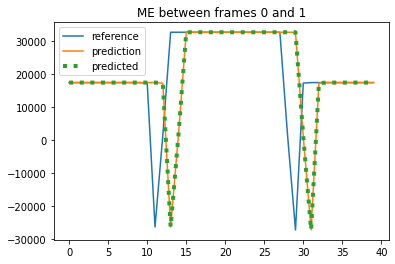

In [12]:
plt.title("ME between frames 0 and 1")
plt.plot(frame_0_Y[35, 0:40], label="reference")
plt.plot(np.roll(frame_0_Y[35, 0:40], 2), label="prediction")
#plt.show()
plt.plot(frame_2_Y[35, 0:40], linestyle=':', linewidth=4, label="predicted")
plt.legend()
plt.savefig("movement_1.svg")
plt.savefig("movement_1.pdf")
plt.show()

### 2D-DWT of the frames

In [13]:
LL_0_haar, (LH_0_haar, HL_0_haar, HH_0_haar) = pywt.dwt2(frame_0_Y, 'haar')
LL_1_haar, (LH_1_haar, HL_1_haar, HH_1_haar) = pywt.dwt2(frame_1_Y, 'haar')
LL_2_haar, (LH_2_haar, HL_2_haar, HH_2_haar) = pywt.dwt2(frame_2_Y, 'haar')

### Interpolation of the L subbands: the [L] subbands

In [14]:
iL_0_haar = pywt.idwt2([LL_0_haar, (None, None, None)], 'haar')
iL_1_haar = pywt.idwt2([LL_1_haar, (None, None, None)], 'haar')
iL_2_haar = pywt.idwt2([LL_2_haar, (None, None, None)], 'haar')

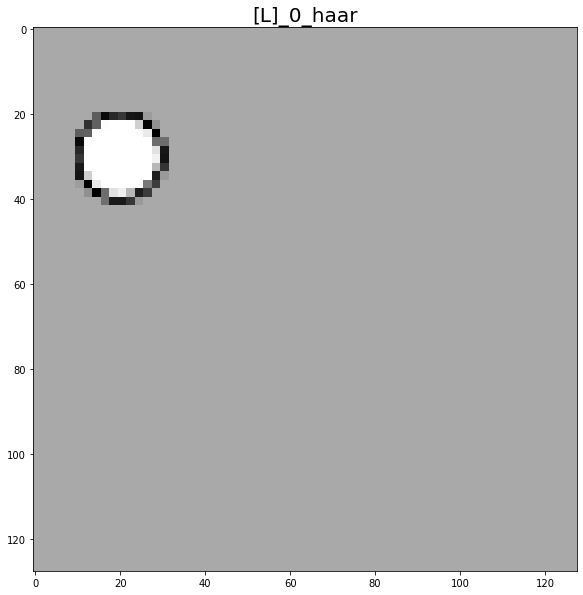

In [15]:
plt.figure(figsize=(10,10))
plt.title("[L]_0_haar", fontsize=20)
plt.imshow(iL_0_haar, cmap='gray')
plt.show()

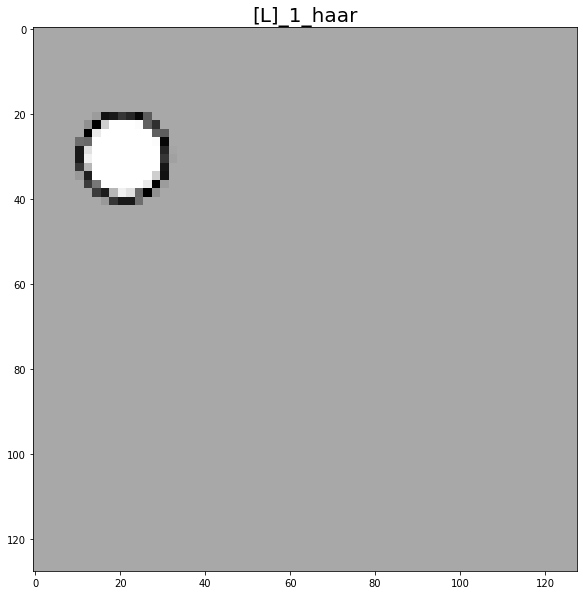

In [16]:
plt.figure(figsize=(10,10))
plt.title("[L]_1_haar", fontsize=20)
plt.imshow(iL_1_haar, cmap='gray')
plt.show()

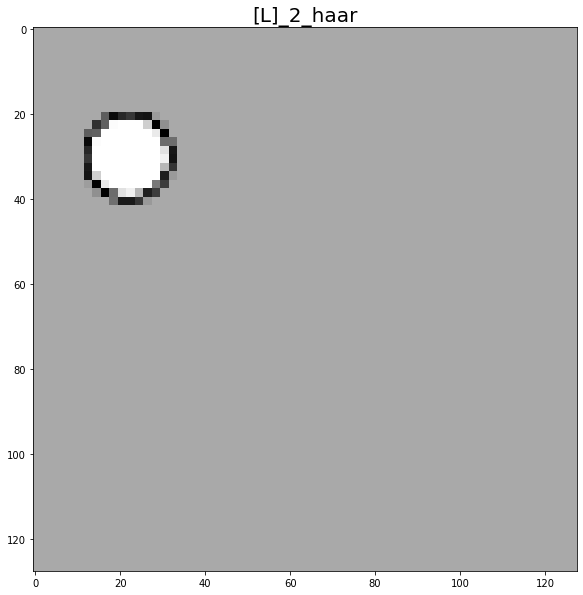

In [17]:
plt.figure(figsize=(10,10))
plt.title("[L]_2_haar", fontsize=20)
plt.imshow(iL_2_haar, cmap='gray')
plt.show()

Notice that the subbands [L] of the frames 0 and 2 have the same coefficients, but this is not true for the frame 1.

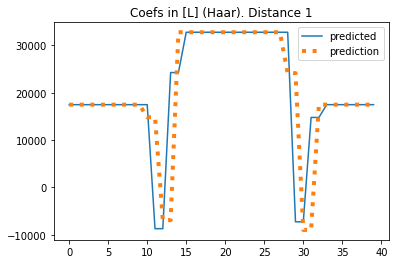

In [18]:
plt.title("Coefs in [L] (Haar). Distance 1")
#plt.plot(iL_0_haar[35, 0:40], label="reference")
plt.plot(np.roll(iL_0_haar[35, 0:40], 1), label="predicted")
plt.plot(iL_1_haar[35, 0:40], linestyle=':', linewidth=4, label="prediction")
plt.legend()
plt.savefig("haar_iL_0.svg")
plt.savefig("haar_iL_0.pdf")
plt.show()

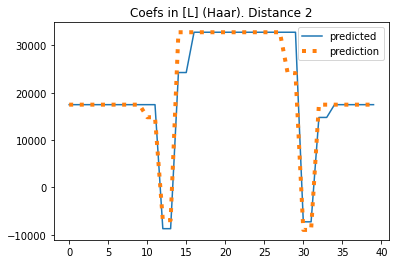

In [19]:
plt.title("Coefs in [L] (Haar). Distance 2")
#plt.plot(iL_0_haar[35, 0:40], label="reference")
plt.plot(np.roll(iL_0_haar[35, 0:40], 2), label="predicted")
plt.plot(iL_1_haar[35, 0:40], linestyle=':', linewidth=4, label="prediction")
plt.legend()
plt.savefig("haar_iL_1.svg")
plt.savefig("haar_iL_1.pdf")
plt.show()

The predicted subband and the prediction subband does not need to be identical to estimate a motion field. For example, a block-based motion estimator should determine here the right displacement between the predicted structure and the reference one.

### Interpolation of the H subbands: the [H] subbands

In [ ]:
iH_0_haar = pywt.idwt2([None,(LH_0_haar, HL_0_haar, HH_0_haar)], 'haar')
iH_1_haar = pywt.idwt2([None,(LH_1_haar, HL_1_haar, HH_1_haar)], 'haar')
iH_2_haar = pywt.idwt2([None,(LH_2_haar, HL_2_haar, HH_2_haar)], 'haar')

In [ ]:
plt.figure(figsize=(10,10))
plt.title("[H]_0_haar", fontsize=20)
plt.imshow(iH_0_haar, cmap='gray')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.title("[H]_1_haar", fontsize=20)
plt.imshow(iH_1_haar, cmap='gray')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.title("[H]_2_haar", fontsize=20)
plt.imshow(iH_2_haar, cmap='gray')
plt.show()

In [ ]:
plt.title("Coefs in [H] (Haar). Distance 1")
plt.plot(np.roll(iH_0_haar[35, 0:40], 1), label="predicted")
plt.plot(iH_1_haar[35, 0:40], linestyle=':', linewidth=4, label="prediction")
plt.legend()
plt.savefig("haar_iH_0.svg")
plt.savefig("haar_iH_0.pdf")
plt.show()

In [ ]:
plt.title("Coefs in [H] (Haar). Distance 2")
plt.plot(np.roll(iH_0_haar[35, 0:40], 2), label="predicted")
plt.plot(iH_2_haar[35, 0:40], linestyle=':', linewidth=4, label="prediction")
plt.legend()
plt.savefig("haar_iH_0.svg")
plt.savefig("haar_iH_0.pdf")
plt.show()

In [ ]:
LL_0_db5, (LH_0_db5, HL_0_db5, HH_0_db5) = pywt.dwt2(frame_0_Y, 'db5')
iL_0_db5 = pywt.idwt2([LL_0_db5, (None, None, None)], 'db5')
LL_1_db5, (LH_1_db5, HL_1_db5, HH_1_db5) = pywt.dwt2(frame_1_Y, 'db5')
iL_1_db5 = pywt.idwt2([LL_1_db5, (None, None, None)], 'db5')

In [ ]:
plt.figure(figsize=(10,10))
plt.title("iL_0_db5", fontsize=20)
plt.imshow(iL_0_db5, cmap='gray')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.title("iL_1_db5", fontsize=20)
plt.imshow(iL_1_db5, cmap='gray')
plt.show()

In [ ]:
plt.title("Coefs in [L] (Daubechies 5)")
plt.plot(np.roll(iL_0_db5[35, 0:40],1), label="predicted")
plt.plot(iL_1_db5[35, 0:40], linestyle=':', linewidth=4, label="prediction")
plt.legend()
plt.savefig("db5_iL.svg")
plt.savefig("db5_iL.pdf")
plt.show()

In [ ]:
LL_0_bior35, (LH_0_bior35, HL_0_bior35, HH_0_bior35) = pywt.dwt2(frame_0_Y, 'bior3.5')
iL_0_bior35 = pywt.idwt2([LL_0_bior35, (None, None, None)], 'bior3.5')
LL_1_bior35, (LH_1_bior35, HL_1_bior35, HH_1_bior35) = pywt.dwt2(frame_1_Y, 'bior3.5')
iL_1_bior35 = pywt.idwt2([LL_1_bior35, (None, None, None)], 'bior3.5')

In [ ]:
plt.figure(figsize=(10,10))
plt.title("iL_0_bior35", fontsize=20)
plt.imshow(iL_0_bior35, cmap='gray')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.title("iL_1_bior35", fontsize=20)
plt.imshow(iL_1_bior35, cmap='gray')
plt.show()

In [ ]:
plt.title("Coefs in [L] (Biorthogonal 3.5)")
plt.plot(np.roll(iL_0_bior35[35, 0:40], 1), label="predicted")
plt.plot(iL_1_bior35[35, 0:40], linestyle=':', linewidth=4, label="prediction")
plt.legend()
plt.savefig("bior35_iL.svg")
plt.savefig("bior35_iL.pdf")
plt.show()

In [ ]:
iH_0_db5 = pywt.idwt2([None,(LH_0_db5, HL_0_db5, HH_0_db5)], 'db5')
iH_1_db5 = pywt.idwt2([None,(LH_1_db5, HL_1_db5, HH_1_db5)], 'db5')

In [ ]:
plt.figure(figsize=(10,10))
plt.title("iH_0_db5", fontsize=20)
plt.imshow(iH_0_db5, cmap='gray')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.title("iH_1_db5", fontsize=20)
plt.imshow(iH_1_db5, cmap='gray')
plt.show()

In [ ]:
plt.title("Coefs in [H] (db5)")
plt.plot(np.roll(iH_0_db5[35, 0:40], 1), label="predicted")
plt.plot(iH_1_db5[35, 0:40], linestyle=':', linewidth=4, label="prediction")
plt.legend()
plt.savefig("db5_iH.svg")
plt.savefig("db5_iH.pdf")
plt.show()

In [ ]:
iH_0_bior35 = pywt.idwt2([None,(LH_0_bior35, HL_0_bior35, HH_0_bior35)], 'bior3.5')
iH_1_bior35 = pywt.idwt2([None,(LH_1_bior35, HL_1_bior35, HH_1_bior35)], 'bior3.5')

In [ ]:
plt.figure(figsize=(10,10))
plt.title("iH_0_bior35", fontsize=20)
plt.imshow(iH_0_bior35, cmap='gray')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.title("iH_1_bior35", fontsize=20)
plt.imshow(iH_1_bior35, cmap='gray')
plt.show()

In [ ]:
plt.title("Coefs in [H] (bior35)")
plt.plot(np.roll(iH_0_bior35[35, 0:40], 1), label="predicted")
plt.plot(iH_1_bior35[35, 0:40], linestyle=':', linewidth=4, label="prediction")
plt.plot(np.roll(iH_1_bior35[35, 0:40][::-1], 3), linestyle=':', linewidth=3, label="prediction b")
plt.legend()
plt.savefig("bior35_iH.svg")
plt.savefig("bior35_iH.pdf")
plt.show()

In [ ]:
iiH_0_bior35 = pywt.idwt2([iH_0_bior35, (None, None, None)], 'bior3.5')
iiH_1_bior35 = pywt.idwt2([iH_1_bior35, (None, None, None)], 'bior3.5')

In [ ]:
plt.title("Coefs in [H] (bior35)")
plt.plot(np.roll(iiH_0_bior35[70, 0:80], 3), label="predicted")
plt.plot(iiH_1_bior35[70, 0:80], linestyle=':', linewidth=4, label="prediction")
plt.legend()
plt.savefig("bior35_iiH.svg")
plt.savefig("bior35_iiH.pdf")
plt.show()

In [ ]:
%%bash

# Create the two images ("/tmp/moving_circle_000.png" and "/tmp/moving_circle_001.png") with a circle
# of diameter 10 that moves from coordinate (20,30) to (21,30).
/home/vruiz/MRVC/tools/moving_circle.sh -w 128 -h 128 -x 20 -y 30 -d 10 -f 3
mv /tmp/moving_circle_000.png .
mv /tmp/moving_circle_002.png .

In [ ]:
frame_2 = load_frame(prefix + "002")
frame_2_Y = RGB_to_YCoCg(frame_2)[:,:,0]

In [ ]:
LL_2_bior35, (LH_2_bior35, HL_2_bior35, HH_2_bior35) = pywt.dwt2(frame_2_Y, 'bior3.5')
iL_2_bior35 = pywt.idwt2([LL_2_bior35, (None, None, None)], 'bior3.5')
iH_2_bior35 = pywt.idwt2([None,(LH_2_bior35, HL_2_bior35, HH_2_bior35)], 'bior3.5')

In [ ]:
plt.title("Coefs in [L] (Biorthogonal 3.5)")
plt.plot(np.roll(iL_0_bior35[35, 0:40], 2), label="predicted")
plt.plot(iL_2_bior35[35, 0:40], linestyle=':', linewidth=4, label="prediction")
plt.legend()
#plt.savefig("bior35_iL.svg")
#plt.savefig("bior35_iL.pdf")
plt.show()

In [ ]:
plt.title("Coefs in [H] (bior35)")
plt.plot(np.roll(iH_0_bior35[35, 0:40], 2), label="predicted")
plt.plot(iH_2_bior35[35, 0:40], linestyle=':', linewidth=4, label="prediction")
plt.legend()
plt.savefig("bior35_iH.svg")
plt.savefig("bior35_iH.pdf")
plt.show()